In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tensorflow.python.framework import random_seed
from matplotlib import pyplot as plt
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb

In [2]:
df_stock = pd.read_csv('ITC.NS.csv')

In [3]:
df_stock.columns = ['Date', 'Stock_Open', 'Stock_High', 'Stock_Low', 'Stock_Close', 'Stock_Adj Close', 'Stock_Volume']

In [4]:
print(df_stock.shape)

(3702, 7)


In [5]:
df_stock.isnull().sum()

Date                0
Stock_Open         14
Stock_High         14
Stock_Low          14
Stock_Close        14
Stock_Adj Close    14
Stock_Volume       14
dtype: int64

In [6]:
df_stock = df_stock.drop(['Date'],axis = 1)

In [7]:
def technical_indicators(df):
    
    new_df = pd.DataFrame()
    
    dm = ((df['Stock_High'] + df['Stock_Low'])/2) - ((df['Stock_High'].shift(1) + df['Stock_Low'].shift(1))/2)
    br = (df['Stock_Volume'] / 100000000) / ((df['Stock_High'] - df['Stock_Low']))
    EVM = dm / br 
    new_df['EVM_15'] = EVM.rolling(15).mean()

    
    sma_60 = pd.Series.rolling(df['Stock_Close'], window=60, center=False).mean()
    new_df["SMA_60"] = sma_60
    
    sma_200 = pd.Series.rolling(df['Stock_Close'], window=30, center=False).mean()
    new_df["SMA_200"] = sma_200
    
    ewma_50 = df['Stock_Close'].ewm(span = 50, min_periods = 50 - 1).mean()
    new_df["EWMA_50"] = ewma_50
    
    ewma_200 = df['Stock_Close'].ewm(span = 200, min_periods = 200 - 1).mean()
    new_df["EWMA_200"] = ewma_200
    
    sma_5 = pd.Series.rolling(df['Stock_Close'], window=5, center=False).mean()
    std_5 = pd.Series.rolling(df['Stock_Close'], window=5, center=False).std()
    bb_5_upper = sma_5 + (2 * std_5)
    bb_5_lower = sma_5 - (2 * std_5)
    new_df["BB_5_UPPER"] = bb_5_upper
    new_df["BB_5_LOWER"] = bb_5_lower
    new_df["SMA_5"] = sma_5
    
    sma_10 = pd.Series.rolling(df['Stock_Close'], window=10, center=False).mean()
    std_10 = pd.Series.rolling(df['Stock_Close'], window=10, center=False).std()
    bb_10_upper = sma_10 + (2 * std_10)
    bb_10_lower = sma_10 - (2 * std_10)
    new_df["BB_10_UPPER"] = bb_10_upper
    new_df["BB_10_LOWER"] = bb_10_lower
    new_df["SMA_10"] = sma_10
    
    sma_20 = pd.Series.rolling(df['Stock_Close'], window=20, center=False).mean()
    std_20 = pd.Series.rolling(df['Stock_Close'], window=20, center=False).std()
    bb_20_upper = sma_20 + (2 * std_20)
    bb_20_lower = sma_20 - (2 * std_20)
    new_df["BB_20_UPPER"] = bb_20_upper
    new_df["BB_20_LOWER"] = bb_20_lower
    new_df["SMA_20"] = sma_20
    
    roc_5 = df['Stock_Close'][5:]/df['Stock_Close'][:-5].values - 1
    new_df["ROC_5"] = roc_5
    
    roc_10 = df['Stock_Close'][10:]/df['Stock_Close'][:-10].values - 1
    new_df["ROC_10"] = roc_10
    
    roc_20 = df['Stock_Close'][20:]/df['Stock_Close'][:-20].values - 1
    new_df["ROC_20"] = roc_20
    
    delta = df['Stock_Close'].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    up_5 = pd.Series.rolling(up, window=5, center=False).mean()
    down_5 = pd.Series.rolling(down.abs(), window=5, center=False).mean()
    RS_5 = up_5 / down_5
    RSI_5 = 100.0 - (100.0 / (1.0 + RS_5))
    new_df["RSI_5"] = RSI_5
    
    up_10 = pd.Series.rolling(up, window=10, center=False).mean()
    down_10 = pd.Series.rolling(down.abs(), window=10, center=False).mean()
    RS_10 = up_10 / down_10
    RSI_10 = 100.0 - (100.0 / (1.0 + RS_10))
    new_df["RSI_10"] = RSI_10
    
    up_20 = pd.Series.rolling(up, window=20, center=False).mean()
    down_20 = pd.Series.rolling(down.abs(), window=20, center=False).mean()
    RS_20 = up_20 / down_20
    RSI_20 = 100.0 - (100.0 / (1.0 + RS_20))
    new_df["RSI_20"] = RSI_20
    
    return new_df

In [8]:
def process_data(df):
    
    temp = df
    
    # Fill missing values in data frame, in place.
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)
    epsilon = 1e-5    
    # log
    df = df.apply(lambda x:np.log(x + epsilon),axis=1)
    temp = technical_indicators(temp)
    
    temp.fillna(method="ffill", inplace=True)
    temp.fillna(method="bfill", inplace=True)
    
    df = pd.concat([df,temp],axis = 1)
    
    
    return df

In [9]:
def get_rolling_data(X,y,train_period,predict_period=1,n_day_later_predict=1):

    assert X.shape[0] == y.shape[0], (
            'X.shape: %s y.shape: %s' % (X.shape, y.shape))
    
    rolling_X, rolling_y = [],[]
    
    for i in range(len(X)-train_period-predict_period-(n_day_later_predict)):

        curr_X=X.iloc[i:i+train_period,:]
        curr_y=y.iloc[i+train_period+n_day_later_predict:i+train_period+predict_period+n_day_later_predict]
        rolling_X.append(curr_X.values.tolist())
        if predict_period == 1:
            rolling_y.append(curr_y.values.tolist()[0])
        else:
            rolling_y.append(curr_y.values.tolist())
        
    rolling_X = np.array(rolling_X)
    rolling_y = np.array(rolling_y)
    return rolling_X, rolling_y

In [10]:
class ModelData():
    
    def __init__(self,X,y,seed=None,shuffle=True):
        seed1, seed2 = random_seed.get_seed(seed)
        # If op level seed is not set, use whatever graph level seed is returned
        self._seed = seed1 if seed is None else seed2
        np.random.seed(self._seed)
        
        assert X.shape[0] == y.shape[0], (
            'X.shape: %s y.shape: %s' % (X.shape, y.shape))
        self._num_examples = X.shape[0]
        
        # If shuffle
        if shuffle:
            np.random.seed(self._seed)
            randomList = np.arange(X.shape[0])
            np.random.shuffle(randomList)
            self._X, self._y = X[randomList], y[randomList] 
        
        self._X = X
        self._y = y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        
    
    def train_validate_test_split(self,validate_size=0.10,test_size=0.10):
        
        validate_start = int(self._num_examples*(1-validate_size-test_size)) + 1
        test_start = int(self._num_examples*(1-test_size)) + 1
        if validate_start > len(self._X) or test_start > len(self._X):
            pass
        train_X,train_y = self._X[:validate_start],self._y[:validate_start]
        validate_X, validate_y = self._X[validate_start:test_start],self._y[validate_start:test_start]
        test_X,test_y = self._X[test_start:],self._y[test_start:]
        
        if test_size == 0:
            return ModelData(train_X,train_y,self._seed), ModelData(validate_X,validate_y,self._seed)
        else:
            return ModelData(train_X,train_y,self._seed), ModelData(validate_X,validate_y,self._seed), ModelData(test_X,test_y,self._seed)

    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y

In [11]:
train_period = 7
predict_period = 1
n_day_later_predict= 7

In [12]:
price_data = process_data(df_stock)
rolling_X, rolling_y = get_rolling_data(price_data, price_data.loc[:,'Stock_Adj Close'], train_period=train_period, 
                                        predict_period=predict_period,
                                        n_day_later_predict=n_day_later_predict)

model_data = ModelData(rolling_X, rolling_y,seed=666,shuffle=False)
model_train_data, model_validate_data = model_data.train_validate_test_split(validate_size=0.10,test_size=0)

In [13]:
price_data

,Stock_Open,Stock_High,Stock_Low,Stock_Close,Stock_Adj Close,Stock_Volume,EVM_15,SMA_60,SMA_200,EWMA_50,...,SMA_10,BB_20_UPPER,BB_20_LOWER,SMA_20,ROC_5,ROC_10,ROC_20,RSI_5,RSI_10,RSI_20
0,3.446808,3.449601,3.411880,3.420893,1.376046,16.161689,-0.462272,33.762852,32.093783,33.883876,...,30.920670,33.147047,29.867523,31.507285,0.012165,0.044194,0.074952,70.303295,72.494652,67.437126
1,3.411514,3.441130,3.401198,3.422597,1.377750,15.989103,-0.462272,33.762852,32.093783,33.883876,...,30.920670,33.147047,29.867523,31.507285,0.012165,0.044194,0.074952,70.303295,72.494652,67.437126
2,3.437350,3.437350,3.414479,3.419620,1.374774,15.841532,-0.462272,33.762852,32.093783,33.883876,...,30.920670,33.147047,29.867523,31.507285,0.012165,0.044194,0.074952,70.303295,72.494652,67.437126
3,3.419548,3.446101,3.412246,3.417691,1.372844,16.859354,-0.462272,33.762852,32.093783,33.883876,...,30.920670,33.147047,29.867523,31.507285,0.012165,0.044194,0.074952,70.303295,72.494652,67.437126
4,3.417691,3.437565,3.408577,3.436922,1.392075,15.865713,-0.462272,33.762852,32.093783,33.883876,...,30.920670,33.147047,29.867523,31.507285,0.012165,0.044194,0.074952,70.303295,72.494652,67.437126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697,5.123369,5.208119,5.117994,5.181222,5.181222,17.956539,15.559910,201.182499,175.353333,188.188262,...,162.164998,188.697470,138.432527,163.564999,0.137468,0.099166,-0.051200,76.807976,58.823525,46.996243
3698,5.224133,5.224133,5.157042,5.201531,5.201531,17.402318,59.809085,200.305000,174.515000,187.927938,...,162.769998,187.179078,139.300919,163.239999,0.112439,0.034473,-0.034565,74.830853,53.736877,48.004911
3699,5.197668,5.214936,5.174170,5.185429,5.185429,17.441479,54.538892,199.352499,173.555000,187.564097,...,165.204997,186.555002,139.614995,163.084998,0.122173,0.157809,-0.017056,77.126898,69.433350,49.028211
3700,5.214936,5.227090,5.192957,5.221706,5.221706,17.567997,58.298742,198.473333,172.963333,187.473348,...,168.759998,188.218936,138.756061,163.487499,0.078917,0.237475,0.045429,72.621020,77.494198,52.491490


In [14]:
price_data.tail(7).values.reshape(-1,1)

array([[ 5.09986649e+00],
       [ 5.15819295e+00],
       [ 5.08481477e+00],
       [ 5.14574881e+00],
       [ 5.14574881e+00],
       [ 1.75680844e+01],
       [-3.50350407e+01],
       [ 2.03285000e+02],
       [ 1.77498334e+02],
       [ 1.89514648e+02],
       [ 2.32006836e+02],
       [ 1.77453728e+02],
       [ 1.41686268e+02],
       [ 1.59569998e+02],
       [ 1.77600557e+02],
       [ 1.40379442e+02],
       [ 1.58989999e+02],
       [ 1.95182179e+02],
       [ 1.35652820e+02],
       [ 1.65417500e+02],
       [ 1.46960591e-01],
       [ 1.51190103e-01],
       [-1.20839763e-01],
       [ 8.17003046e+01],
       [ 6.29821562e+01],
       [ 4.21750637e+01],
       [ 5.14574881e+00],
       [ 5.15184552e+00],
       [ 5.10321455e+00],
       [ 5.11439455e+00],
       [ 5.11439455e+00],
       [ 1.67137386e+01],
       [-2.98640677e+01],
       [ 2.02140000e+02],
       [ 1.76218333e+02],
       [ 1.88608191e+02],
       [ 2.31354032e+02],
       [ 1.75403640e+02],
       [ 1.5

In [15]:
# process data's dimension
y_train = model_train_data.y[:,np.newaxis]
y_validate = model_validate_data.y[:,np.newaxis]

X_train = model_train_data.X
X_validate = model_validate_data.X

In [16]:
X_train.shape

(3319, 7, 26)

In [17]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_validate = X_validate.reshape((X_validate.shape[0],X_validate.shape[1]*X_validate.shape[2]))

In [18]:
reg = xgb.XGBRegressor(n_estimators=10000,min_child_weight= 40,learning_rate=0.01,colsample_bytree = 1,subsample = 0.9)
reg.fit(X_train, y_train,eval_set = [(X_validate[:300],y_validate[:300])],early_stopping_rounds = 50) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:5.04480
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:4.99487
[2]	validation_0-rmse:4.94550
[3]	validation_0-rmse:4.89656
[4]	validation_0-rmse:4.84971
[5]	validation_0-rmse:4.80192
[6]	validation_0-rmse:4.75448
[7]	validation_0-rmse:4.70751
[8]	validation_0-rmse:4.66092
[9]	validation_0-rmse:4.61483
[10]	validation_0-rmse:4.56937
[11]	validation_0-rmse:4.52419
[12]	validation_0-rmse:4.47966
[13]	validation_0-rmse:4.43534
[14]	validation_0-rmse:4.39169
[15]	validation_0-rmse:4.34858
[16]	validation_0-rmse:4.30557
[17]	validation_0-rmse:4.26278
[18]	validation_0-rmse:4.22101
[19]	validation_0-rmse:4.18057
[20]	validation_0-rmse:4.13943
[21]	validation_0-rmse:4.09886
[22]	validation_0-rmse:4.05814
[23]	validation_0-rmse:4.01840
[24]	validation_0-rmse:3.97992
[25]	validation_0-rmse:3.94175
[26]	validation_0-rmse:3.90396
[27]	validation_0-rmse:3.86517
[28]	validation_0-rmse:3.82717
[29]	validation_0-rmse:3.78938
[30]	validation

[258]	validation_0-rmse:0.39679
[259]	validation_0-rmse:0.39293
[260]	validation_0-rmse:0.38900
[261]	validation_0-rmse:0.38522
[262]	validation_0-rmse:0.38143
[263]	validation_0-rmse:0.37767
[264]	validation_0-rmse:0.37401
[265]	validation_0-rmse:0.37045
[266]	validation_0-rmse:0.36677
[267]	validation_0-rmse:0.36322
[268]	validation_0-rmse:0.35962
[269]	validation_0-rmse:0.35611
[270]	validation_0-rmse:0.35271
[271]	validation_0-rmse:0.34930
[272]	validation_0-rmse:0.34591
[273]	validation_0-rmse:0.34244
[274]	validation_0-rmse:0.33906
[275]	validation_0-rmse:0.33579
[276]	validation_0-rmse:0.33252
[277]	validation_0-rmse:0.32931
[278]	validation_0-rmse:0.32616
[279]	validation_0-rmse:0.32306
[280]	validation_0-rmse:0.31992
[281]	validation_0-rmse:0.31696
[282]	validation_0-rmse:0.31385
[283]	validation_0-rmse:0.31081
[284]	validation_0-rmse:0.30772
[285]	validation_0-rmse:0.30468
[286]	validation_0-rmse:0.30172
[287]	validation_0-rmse:0.29873
[288]	validation_0-rmse:0.29585
[289]	va

[515]	validation_0-rmse:0.05112
[516]	validation_0-rmse:0.05093
[517]	validation_0-rmse:0.05072
[518]	validation_0-rmse:0.05052
[519]	validation_0-rmse:0.05037
[520]	validation_0-rmse:0.05017
[521]	validation_0-rmse:0.05004
[522]	validation_0-rmse:0.04991
[523]	validation_0-rmse:0.04972
[524]	validation_0-rmse:0.04958
[525]	validation_0-rmse:0.04938
[526]	validation_0-rmse:0.04920
[527]	validation_0-rmse:0.04903
[528]	validation_0-rmse:0.04889
[529]	validation_0-rmse:0.04872
[530]	validation_0-rmse:0.04856
[531]	validation_0-rmse:0.04844
[532]	validation_0-rmse:0.04828
[533]	validation_0-rmse:0.04814
[534]	validation_0-rmse:0.04802
[535]	validation_0-rmse:0.04789
[536]	validation_0-rmse:0.04774
[537]	validation_0-rmse:0.04753
[538]	validation_0-rmse:0.04737
[539]	validation_0-rmse:0.04720
[540]	validation_0-rmse:0.04706
[541]	validation_0-rmse:0.04690
[542]	validation_0-rmse:0.04676
[543]	validation_0-rmse:0.04661
[544]	validation_0-rmse:0.04645
[545]	validation_0-rmse:0.04627
[546]	va

[772]	validation_0-rmse:0.03753
[773]	validation_0-rmse:0.03752
[774]	validation_0-rmse:0.03751
[775]	validation_0-rmse:0.03750
[776]	validation_0-rmse:0.03751
[777]	validation_0-rmse:0.03750
[778]	validation_0-rmse:0.03750
[779]	validation_0-rmse:0.03749
[780]	validation_0-rmse:0.03749
[781]	validation_0-rmse:0.03749
[782]	validation_0-rmse:0.03748
[783]	validation_0-rmse:0.03750
[784]	validation_0-rmse:0.03748
[785]	validation_0-rmse:0.03747
[786]	validation_0-rmse:0.03746
[787]	validation_0-rmse:0.03746
[788]	validation_0-rmse:0.03745
[789]	validation_0-rmse:0.03745
[790]	validation_0-rmse:0.03744
[791]	validation_0-rmse:0.03744
[792]	validation_0-rmse:0.03744
[793]	validation_0-rmse:0.03744
[794]	validation_0-rmse:0.03745
[795]	validation_0-rmse:0.03744
[796]	validation_0-rmse:0.03743
[797]	validation_0-rmse:0.03743
[798]	validation_0-rmse:0.03743
[799]	validation_0-rmse:0.03743
[800]	validation_0-rmse:0.03743
[801]	validation_0-rmse:0.03743
[802]	validation_0-rmse:0.03744
[803]	va

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=40, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.9, tree_method=None,
             validate_parameters=False, verbosity=None)

In [19]:
model = CatBoostRegressor(iterations=10000,
                          learning_rate=0.005,
                          loss_function = 'RMSE')

model.fit(X_train, y_train,
          eval_set = [(X_validate[:300],y_validate[:300])],
        early_stopping_rounds = 50,
       verbose=True)

0:	learn: 0.8524473	test: 0.9887151	best: 0.9887151 (0)	total: 147ms	remaining: 24m 25s
1:	learn: 0.8484666	test: 0.9847243	best: 0.9847243 (1)	total: 176ms	remaining: 14m 38s
2:	learn: 0.8444806	test: 0.9799486	best: 0.9799486 (2)	total: 204ms	remaining: 11m 20s
3:	learn: 0.8404590	test: 0.9755943	best: 0.9755943 (3)	total: 234ms	remaining: 9m 43s
4:	learn: 0.8366622	test: 0.9715370	best: 0.9715370 (4)	total: 262ms	remaining: 8m 43s
5:	learn: 0.8328575	test: 0.9675313	best: 0.9675313 (5)	total: 290ms	remaining: 8m 3s
6:	learn: 0.8290558	test: 0.9638248	best: 0.9638248 (6)	total: 319ms	remaining: 7m 34s
7:	learn: 0.8252336	test: 0.9593138	best: 0.9593138 (7)	total: 349ms	remaining: 7m 16s
8:	learn: 0.8213854	test: 0.9550283	best: 0.9550283 (8)	total: 392ms	remaining: 7m 15s
9:	learn: 0.8175030	test: 0.9506945	best: 0.9506945 (9)	total: 426ms	remaining: 7m 5s
10:	learn: 0.8137842	test: 0.9467526	best: 0.9467526 (10)	total: 455ms	remaining: 6m 53s
11:	learn: 0.8099689	test: 0.9425599	bes

98:	learn: 0.5402799	test: 0.6525039	best: 0.6525039 (98)	total: 3.26s	remaining: 5m 25s
99:	learn: 0.5377369	test: 0.6495513	best: 0.6495513 (99)	total: 3.3s	remaining: 5m 26s
100:	learn: 0.5352511	test: 0.6470041	best: 0.6470041 (100)	total: 3.33s	remaining: 5m 26s
101:	learn: 0.5327995	test: 0.6440845	best: 0.6440845 (101)	total: 3.35s	remaining: 5m 25s
102:	learn: 0.5303316	test: 0.6415661	best: 0.6415661 (102)	total: 3.38s	remaining: 5m 25s
103:	learn: 0.5279504	test: 0.6391956	best: 0.6391956 (103)	total: 3.41s	remaining: 5m 24s
104:	learn: 0.5254658	test: 0.6363327	best: 0.6363327 (104)	total: 3.44s	remaining: 5m 24s
105:	learn: 0.5229980	test: 0.6336423	best: 0.6336423 (105)	total: 3.48s	remaining: 5m 24s
106:	learn: 0.5206318	test: 0.6311369	best: 0.6311369 (106)	total: 3.53s	remaining: 5m 26s
107:	learn: 0.5182239	test: 0.6286433	best: 0.6286433 (107)	total: 3.56s	remaining: 5m 26s
108:	learn: 0.5158470	test: 0.6261804	best: 0.6261804 (108)	total: 3.6s	remaining: 5m 26s
109:	

195:	learn: 0.3467198	test: 0.4325780	best: 0.4325780 (195)	total: 6.27s	remaining: 5m 13s
196:	learn: 0.3451478	test: 0.4307031	best: 0.4307031 (196)	total: 6.31s	remaining: 5m 13s
197:	learn: 0.3436273	test: 0.4290974	best: 0.4290974 (197)	total: 6.34s	remaining: 5m 13s
198:	learn: 0.3420534	test: 0.4271954	best: 0.4271954 (198)	total: 6.37s	remaining: 5m 13s
199:	learn: 0.3405213	test: 0.4253234	best: 0.4253234 (199)	total: 6.4s	remaining: 5m 13s
200:	learn: 0.3389683	test: 0.4234618	best: 0.4234618 (200)	total: 6.42s	remaining: 5m 13s
201:	learn: 0.3374213	test: 0.4216090	best: 0.4216090 (201)	total: 6.45s	remaining: 5m 13s
202:	learn: 0.3359163	test: 0.4198638	best: 0.4198638 (202)	total: 6.49s	remaining: 5m 13s
203:	learn: 0.3344109	test: 0.4180351	best: 0.4180351 (203)	total: 6.52s	remaining: 5m 13s
204:	learn: 0.3329323	test: 0.4163469	best: 0.4163469 (204)	total: 6.55s	remaining: 5m 13s
205:	learn: 0.3314296	test: 0.4144253	best: 0.4144253 (205)	total: 6.58s	remaining: 5m 12s


286:	learn: 0.2324012	test: 0.2957602	best: 0.2957602 (286)	total: 9.09s	remaining: 5m 7s
287:	learn: 0.2314065	test: 0.2945427	best: 0.2945427 (287)	total: 9.12s	remaining: 5m 7s
288:	learn: 0.2304030	test: 0.2933107	best: 0.2933107 (288)	total: 9.15s	remaining: 5m 7s
289:	learn: 0.2294113	test: 0.2920785	best: 0.2920785 (289)	total: 9.18s	remaining: 5m 7s
290:	learn: 0.2284214	test: 0.2908384	best: 0.2908384 (290)	total: 9.21s	remaining: 5m 7s
291:	learn: 0.2274596	test: 0.2899265	best: 0.2899265 (291)	total: 9.24s	remaining: 5m 7s
292:	learn: 0.2265022	test: 0.2887322	best: 0.2887322 (292)	total: 9.27s	remaining: 5m 7s
293:	learn: 0.2255310	test: 0.2876119	best: 0.2876119 (293)	total: 9.3s	remaining: 5m 7s
294:	learn: 0.2245600	test: 0.2864245	best: 0.2864245 (294)	total: 9.34s	remaining: 5m 7s
295:	learn: 0.2236131	test: 0.2854638	best: 0.2854638 (295)	total: 9.37s	remaining: 5m 7s
296:	learn: 0.2226515	test: 0.2842196	best: 0.2842196 (296)	total: 9.4s	remaining: 5m 7s
297:	learn: 

384:	learn: 0.1557042	test: 0.1984740	best: 0.1984740 (384)	total: 12.1s	remaining: 5m 2s
385:	learn: 0.1551104	test: 0.1977458	best: 0.1977458 (385)	total: 12.2s	remaining: 5m 2s
386:	learn: 0.1544986	test: 0.1968524	best: 0.1968524 (386)	total: 12.2s	remaining: 5m 2s
387:	learn: 0.1539077	test: 0.1961016	best: 0.1961016 (387)	total: 12.2s	remaining: 5m 2s
388:	learn: 0.1533241	test: 0.1952782	best: 0.1952782 (388)	total: 12.2s	remaining: 5m 2s
389:	learn: 0.1527347	test: 0.1944621	best: 0.1944621 (389)	total: 12.3s	remaining: 5m 2s
390:	learn: 0.1521487	test: 0.1936298	best: 0.1936298 (390)	total: 12.3s	remaining: 5m 2s
391:	learn: 0.1515437	test: 0.1928715	best: 0.1928715 (391)	total: 12.3s	remaining: 5m 2s
392:	learn: 0.1509725	test: 0.1921452	best: 0.1921452 (392)	total: 12.4s	remaining: 5m 2s
393:	learn: 0.1504028	test: 0.1913727	best: 0.1913727 (393)	total: 12.4s	remaining: 5m 2s
394:	learn: 0.1498457	test: 0.1908397	best: 0.1908397 (394)	total: 12.4s	remaining: 5m 2s
395:	learn

482:	learn: 0.1103050	test: 0.1368738	best: 0.1368738 (482)	total: 15.1s	remaining: 4m 57s
483:	learn: 0.1099521	test: 0.1362848	best: 0.1362848 (483)	total: 15.2s	remaining: 4m 58s
484:	learn: 0.1096168	test: 0.1358849	best: 0.1358849 (484)	total: 15.2s	remaining: 4m 58s
485:	learn: 0.1092784	test: 0.1353996	best: 0.1353996 (485)	total: 15.2s	remaining: 4m 57s
486:	learn: 0.1089434	test: 0.1350551	best: 0.1350551 (486)	total: 15.2s	remaining: 4m 57s
487:	learn: 0.1086011	test: 0.1345841	best: 0.1345841 (487)	total: 15.3s	remaining: 4m 57s
488:	learn: 0.1082690	test: 0.1340863	best: 0.1340863 (488)	total: 15.3s	remaining: 4m 57s
489:	learn: 0.1079262	test: 0.1336862	best: 0.1336862 (489)	total: 15.3s	remaining: 4m 57s
490:	learn: 0.1075798	test: 0.1332374	best: 0.1332374 (490)	total: 15.4s	remaining: 4m 57s
491:	learn: 0.1072478	test: 0.1327147	best: 0.1327147 (491)	total: 15.4s	remaining: 4m 57s
492:	learn: 0.1069162	test: 0.1321916	best: 0.1321916 (492)	total: 15.4s	remaining: 4m 57s

573:	learn: 0.0859157	test: 0.0998443	best: 0.0998443 (573)	total: 17.9s	remaining: 4m 54s
574:	learn: 0.0857166	test: 0.0995422	best: 0.0995422 (574)	total: 17.9s	remaining: 4m 54s
575:	learn: 0.0854997	test: 0.0992306	best: 0.0992306 (575)	total: 18s	remaining: 4m 54s
576:	learn: 0.0853102	test: 0.0989461	best: 0.0989461 (576)	total: 18s	remaining: 4m 54s
577:	learn: 0.0851193	test: 0.0985575	best: 0.0985575 (577)	total: 18s	remaining: 4m 54s
578:	learn: 0.0849370	test: 0.0981877	best: 0.0981877 (578)	total: 18.1s	remaining: 4m 54s
579:	learn: 0.0847340	test: 0.0978931	best: 0.0978931 (579)	total: 18.1s	remaining: 4m 54s
580:	learn: 0.0845425	test: 0.0976971	best: 0.0976971 (580)	total: 18.1s	remaining: 4m 54s
581:	learn: 0.0843497	test: 0.0973119	best: 0.0973119 (581)	total: 18.2s	remaining: 4m 54s
582:	learn: 0.0841397	test: 0.0970168	best: 0.0970168 (582)	total: 18.2s	remaining: 4m 54s
583:	learn: 0.0839314	test: 0.0966991	best: 0.0966991 (583)	total: 18.2s	remaining: 4m 53s
584:	

664:	learn: 0.0716298	test: 0.0763224	best: 0.0763224 (664)	total: 20.7s	remaining: 4m 50s
665:	learn: 0.0715228	test: 0.0760512	best: 0.0760512 (665)	total: 20.8s	remaining: 4m 50s
666:	learn: 0.0713966	test: 0.0758746	best: 0.0758746 (666)	total: 20.8s	remaining: 4m 50s
667:	learn: 0.0712707	test: 0.0757239	best: 0.0757239 (667)	total: 20.8s	remaining: 4m 50s
668:	learn: 0.0711549	test: 0.0754641	best: 0.0754641 (668)	total: 20.8s	remaining: 4m 50s
669:	learn: 0.0710531	test: 0.0753441	best: 0.0753441 (669)	total: 20.9s	remaining: 4m 50s
670:	learn: 0.0709381	test: 0.0751315	best: 0.0751315 (670)	total: 20.9s	remaining: 4m 50s
671:	learn: 0.0708181	test: 0.0749189	best: 0.0749189 (671)	total: 20.9s	remaining: 4m 50s
672:	learn: 0.0707065	test: 0.0747215	best: 0.0747215 (672)	total: 21s	remaining: 4m 50s
673:	learn: 0.0705982	test: 0.0745467	best: 0.0745467 (673)	total: 21s	remaining: 4m 50s
674:	learn: 0.0704770	test: 0.0743642	best: 0.0743642 (674)	total: 21s	remaining: 4m 50s
675:	

755:	learn: 0.0634376	test: 0.0619360	best: 0.0619360 (755)	total: 23.5s	remaining: 4m 47s
756:	learn: 0.0633546	test: 0.0618121	best: 0.0618121 (756)	total: 23.6s	remaining: 4m 47s
757:	learn: 0.0632792	test: 0.0617000	best: 0.0617000 (757)	total: 23.6s	remaining: 4m 47s
758:	learn: 0.0632177	test: 0.0615875	best: 0.0615875 (758)	total: 23.6s	remaining: 4m 47s
759:	learn: 0.0631405	test: 0.0614420	best: 0.0614420 (759)	total: 23.7s	remaining: 4m 47s
760:	learn: 0.0630812	test: 0.0612933	best: 0.0612933 (760)	total: 23.7s	remaining: 4m 47s
761:	learn: 0.0630200	test: 0.0611730	best: 0.0611730 (761)	total: 23.7s	remaining: 4m 47s
762:	learn: 0.0629506	test: 0.0610605	best: 0.0610605 (762)	total: 23.8s	remaining: 4m 47s
763:	learn: 0.0628914	test: 0.0609241	best: 0.0609241 (763)	total: 23.8s	remaining: 4m 47s
764:	learn: 0.0628232	test: 0.0608090	best: 0.0608090 (764)	total: 23.9s	remaining: 4m 48s
765:	learn: 0.0627724	test: 0.0606799	best: 0.0606799 (765)	total: 23.9s	remaining: 4m 48s

849:	learn: 0.0583854	test: 0.0532389	best: 0.0532389 (849)	total: 26.6s	remaining: 4m 46s
850:	learn: 0.0583505	test: 0.0531541	best: 0.0531541 (850)	total: 26.6s	remaining: 4m 46s
851:	learn: 0.0582971	test: 0.0530779	best: 0.0530779 (851)	total: 26.6s	remaining: 4m 46s
852:	learn: 0.0582541	test: 0.0530105	best: 0.0530105 (852)	total: 26.7s	remaining: 4m 46s
853:	learn: 0.0582088	test: 0.0529618	best: 0.0529618 (853)	total: 26.7s	remaining: 4m 45s
854:	learn: 0.0581697	test: 0.0528714	best: 0.0528714 (854)	total: 26.7s	remaining: 4m 45s
855:	learn: 0.0581243	test: 0.0527932	best: 0.0527932 (855)	total: 26.8s	remaining: 4m 45s
856:	learn: 0.0580838	test: 0.0527310	best: 0.0527310 (856)	total: 26.8s	remaining: 4m 45s
857:	learn: 0.0580462	test: 0.0526479	best: 0.0526479 (857)	total: 26.8s	remaining: 4m 45s
858:	learn: 0.0580090	test: 0.0525835	best: 0.0525835 (858)	total: 26.9s	remaining: 4m 45s
859:	learn: 0.0579622	test: 0.0525158	best: 0.0525158 (859)	total: 26.9s	remaining: 4m 45s

940:	learn: 0.0551542	test: 0.0480886	best: 0.0480886 (940)	total: 29.4s	remaining: 4m 42s
941:	learn: 0.0551253	test: 0.0480260	best: 0.0480260 (941)	total: 29.4s	remaining: 4m 42s
942:	learn: 0.0550928	test: 0.0480084	best: 0.0480084 (942)	total: 29.4s	remaining: 4m 42s
943:	learn: 0.0550633	test: 0.0479697	best: 0.0479697 (943)	total: 29.5s	remaining: 4m 42s
944:	learn: 0.0550350	test: 0.0479279	best: 0.0479279 (944)	total: 29.5s	remaining: 4m 42s
945:	learn: 0.0550050	test: 0.0478970	best: 0.0478970 (945)	total: 29.5s	remaining: 4m 42s
946:	learn: 0.0549774	test: 0.0478499	best: 0.0478499 (946)	total: 29.6s	remaining: 4m 42s
947:	learn: 0.0549509	test: 0.0478052	best: 0.0478052 (947)	total: 29.6s	remaining: 4m 42s
948:	learn: 0.0549212	test: 0.0477628	best: 0.0477628 (948)	total: 29.6s	remaining: 4m 42s
949:	learn: 0.0548910	test: 0.0477340	best: 0.0477340 (949)	total: 29.7s	remaining: 4m 42s
950:	learn: 0.0548667	test: 0.0477087	best: 0.0477087 (950)	total: 29.7s	remaining: 4m 42s

1031:	learn: 0.0529141	test: 0.0453895	best: 0.0453895 (1031)	total: 32.2s	remaining: 4m 39s
1032:	learn: 0.0528924	test: 0.0453713	best: 0.0453713 (1032)	total: 32.2s	remaining: 4m 39s
1033:	learn: 0.0528722	test: 0.0453661	best: 0.0453661 (1033)	total: 32.2s	remaining: 4m 39s
1034:	learn: 0.0528420	test: 0.0453520	best: 0.0453520 (1034)	total: 32.3s	remaining: 4m 39s
1035:	learn: 0.0528206	test: 0.0453387	best: 0.0453387 (1035)	total: 32.3s	remaining: 4m 39s
1036:	learn: 0.0527906	test: 0.0453120	best: 0.0453120 (1036)	total: 32.3s	remaining: 4m 39s
1037:	learn: 0.0527710	test: 0.0452925	best: 0.0452925 (1037)	total: 32.4s	remaining: 4m 39s
1038:	learn: 0.0527519	test: 0.0452548	best: 0.0452548 (1038)	total: 32.4s	remaining: 4m 39s
1039:	learn: 0.0527319	test: 0.0452498	best: 0.0452498 (1039)	total: 32.4s	remaining: 4m 39s
1040:	learn: 0.0527095	test: 0.0452381	best: 0.0452381 (1040)	total: 32.4s	remaining: 4m 39s
1041:	learn: 0.0526950	test: 0.0452111	best: 0.0452111 (1041)	total: 3

1122:	learn: 0.0511732	test: 0.0439267	best: 0.0439250 (1121)	total: 35s	remaining: 4m 36s
1123:	learn: 0.0511582	test: 0.0439029	best: 0.0439029 (1123)	total: 35s	remaining: 4m 36s
1124:	learn: 0.0511408	test: 0.0438918	best: 0.0438918 (1124)	total: 35s	remaining: 4m 36s
1125:	learn: 0.0511222	test: 0.0438776	best: 0.0438776 (1125)	total: 35.1s	remaining: 4m 36s
1126:	learn: 0.0511110	test: 0.0438552	best: 0.0438552 (1126)	total: 35.1s	remaining: 4m 36s
1127:	learn: 0.0510892	test: 0.0438372	best: 0.0438372 (1127)	total: 35.1s	remaining: 4m 36s
1128:	learn: 0.0510738	test: 0.0438154	best: 0.0438154 (1128)	total: 35.1s	remaining: 4m 36s
1129:	learn: 0.0510579	test: 0.0438186	best: 0.0438154 (1128)	total: 35.2s	remaining: 4m 36s
1130:	learn: 0.0510413	test: 0.0437915	best: 0.0437915 (1130)	total: 35.2s	remaining: 4m 36s
1131:	learn: 0.0510235	test: 0.0437650	best: 0.0437650 (1131)	total: 35.2s	remaining: 4m 36s
1132:	learn: 0.0510084	test: 0.0437608	best: 0.0437608 (1132)	total: 35.3s	r

1213:	learn: 0.0497461	test: 0.0429546	best: 0.0429546 (1213)	total: 37.7s	remaining: 4m 33s
1214:	learn: 0.0497342	test: 0.0429324	best: 0.0429324 (1214)	total: 37.8s	remaining: 4m 33s
1215:	learn: 0.0497164	test: 0.0429309	best: 0.0429309 (1215)	total: 37.8s	remaining: 4m 33s
1216:	learn: 0.0497060	test: 0.0429452	best: 0.0429309 (1215)	total: 37.8s	remaining: 4m 33s
1217:	learn: 0.0496933	test: 0.0429454	best: 0.0429309 (1215)	total: 37.9s	remaining: 4m 32s
1218:	learn: 0.0496755	test: 0.0429309	best: 0.0429309 (1218)	total: 37.9s	remaining: 4m 32s
1219:	learn: 0.0496480	test: 0.0429242	best: 0.0429242 (1219)	total: 37.9s	remaining: 4m 32s
1220:	learn: 0.0496283	test: 0.0429217	best: 0.0429217 (1220)	total: 38s	remaining: 4m 32s
1221:	learn: 0.0496108	test: 0.0429174	best: 0.0429174 (1221)	total: 38s	remaining: 4m 32s
1222:	learn: 0.0495955	test: 0.0429196	best: 0.0429174 (1221)	total: 38s	remaining: 4m 32s
1223:	learn: 0.0495834	test: 0.0429170	best: 0.0429170 (1223)	total: 38s	rem

1304:	learn: 0.0484722	test: 0.0424394	best: 0.0424394 (1304)	total: 40.5s	remaining: 4m 30s
1305:	learn: 0.0484622	test: 0.0424370	best: 0.0424370 (1305)	total: 40.6s	remaining: 4m 30s
1306:	learn: 0.0484468	test: 0.0424369	best: 0.0424369 (1306)	total: 40.6s	remaining: 4m 30s
1307:	learn: 0.0484304	test: 0.0424347	best: 0.0424347 (1307)	total: 40.6s	remaining: 4m 29s
1308:	learn: 0.0484186	test: 0.0424236	best: 0.0424236 (1308)	total: 40.7s	remaining: 4m 29s
1309:	learn: 0.0483997	test: 0.0424191	best: 0.0424191 (1309)	total: 40.7s	remaining: 4m 29s
1310:	learn: 0.0483896	test: 0.0424222	best: 0.0424191 (1309)	total: 40.7s	remaining: 4m 29s
1311:	learn: 0.0483800	test: 0.0424216	best: 0.0424191 (1309)	total: 40.7s	remaining: 4m 29s
1312:	learn: 0.0483714	test: 0.0424390	best: 0.0424191 (1309)	total: 40.8s	remaining: 4m 29s
1313:	learn: 0.0483618	test: 0.0424404	best: 0.0424191 (1309)	total: 40.8s	remaining: 4m 29s
1314:	learn: 0.0483513	test: 0.0424317	best: 0.0424191 (1309)	total: 4

1396:	learn: 0.0474485	test: 0.0422577	best: 0.0422577 (1396)	total: 43.3s	remaining: 4m 26s
1397:	learn: 0.0474354	test: 0.0422580	best: 0.0422577 (1396)	total: 43.4s	remaining: 4m 26s
1398:	learn: 0.0474236	test: 0.0422603	best: 0.0422577 (1396)	total: 43.4s	remaining: 4m 26s
1399:	learn: 0.0474109	test: 0.0422574	best: 0.0422574 (1399)	total: 43.4s	remaining: 4m 26s
1400:	learn: 0.0473997	test: 0.0422402	best: 0.0422402 (1400)	total: 43.5s	remaining: 4m 26s
1401:	learn: 0.0473899	test: 0.0422530	best: 0.0422402 (1400)	total: 43.5s	remaining: 4m 26s
1402:	learn: 0.0473829	test: 0.0422529	best: 0.0422402 (1400)	total: 43.5s	remaining: 4m 26s
1403:	learn: 0.0473751	test: 0.0422476	best: 0.0422402 (1400)	total: 43.5s	remaining: 4m 26s
1404:	learn: 0.0473558	test: 0.0422451	best: 0.0422402 (1400)	total: 43.6s	remaining: 4m 26s
1405:	learn: 0.0473403	test: 0.0422457	best: 0.0422402 (1400)	total: 43.6s	remaining: 4m 26s
1406:	learn: 0.0473347	test: 0.0422423	best: 0.0422402 (1400)	total: 4

1486:	learn: 0.0464850	test: 0.0420230	best: 0.0420131 (1480)	total: 46.1s	remaining: 4m 24s
1487:	learn: 0.0464761	test: 0.0420217	best: 0.0420131 (1480)	total: 46.2s	remaining: 4m 24s
1488:	learn: 0.0464697	test: 0.0420204	best: 0.0420131 (1480)	total: 46.2s	remaining: 4m 24s
1489:	learn: 0.0464614	test: 0.0420367	best: 0.0420131 (1480)	total: 46.2s	remaining: 4m 23s
1490:	learn: 0.0464515	test: 0.0420343	best: 0.0420131 (1480)	total: 46.2s	remaining: 4m 23s
1491:	learn: 0.0464419	test: 0.0420261	best: 0.0420131 (1480)	total: 46.3s	remaining: 4m 23s
1492:	learn: 0.0464299	test: 0.0420244	best: 0.0420131 (1480)	total: 46.3s	remaining: 4m 23s
1493:	learn: 0.0464224	test: 0.0420257	best: 0.0420131 (1480)	total: 46.3s	remaining: 4m 23s
1494:	learn: 0.0464089	test: 0.0420242	best: 0.0420131 (1480)	total: 46.4s	remaining: 4m 23s
1495:	learn: 0.0464028	test: 0.0420118	best: 0.0420118 (1495)	total: 46.4s	remaining: 4m 23s
1496:	learn: 0.0463922	test: 0.0420140	best: 0.0420118 (1495)	total: 4

1577:	learn: 0.0455561	test: 0.0419343	best: 0.0419343 (1577)	total: 48.9s	remaining: 4m 20s
1578:	learn: 0.0455507	test: 0.0419370	best: 0.0419343 (1577)	total: 48.9s	remaining: 4m 20s
1579:	learn: 0.0455458	test: 0.0419370	best: 0.0419343 (1577)	total: 49s	remaining: 4m 20s
1580:	learn: 0.0455386	test: 0.0419372	best: 0.0419343 (1577)	total: 49s	remaining: 4m 20s
1581:	learn: 0.0455325	test: 0.0419608	best: 0.0419343 (1577)	total: 49s	remaining: 4m 20s
1582:	learn: 0.0455232	test: 0.0419741	best: 0.0419343 (1577)	total: 49s	remaining: 4m 20s
1583:	learn: 0.0455135	test: 0.0419741	best: 0.0419343 (1577)	total: 49.1s	remaining: 4m 20s
1584:	learn: 0.0455030	test: 0.0419755	best: 0.0419343 (1577)	total: 49.1s	remaining: 4m 20s
1585:	learn: 0.0454955	test: 0.0419815	best: 0.0419343 (1577)	total: 49.1s	remaining: 4m 20s
1586:	learn: 0.0454912	test: 0.0419812	best: 0.0419343 (1577)	total: 49.2s	remaining: 4m 20s
1587:	learn: 0.0454835	test: 0.0419803	best: 0.0419343 (1577)	total: 49.2s	rem

1668:	learn: 0.0447109	test: 0.0418766	best: 0.0418687 (1656)	total: 51.7s	remaining: 4m 17s
1669:	learn: 0.0447046	test: 0.0418773	best: 0.0418687 (1656)	total: 51.7s	remaining: 4m 17s
1670:	learn: 0.0446956	test: 0.0418848	best: 0.0418687 (1656)	total: 51.7s	remaining: 4m 17s
1671:	learn: 0.0446866	test: 0.0418817	best: 0.0418687 (1656)	total: 51.8s	remaining: 4m 17s
1672:	learn: 0.0446834	test: 0.0418813	best: 0.0418687 (1656)	total: 51.8s	remaining: 4m 17s
1673:	learn: 0.0446753	test: 0.0418782	best: 0.0418687 (1656)	total: 51.8s	remaining: 4m 17s
1674:	learn: 0.0446692	test: 0.0418793	best: 0.0418687 (1656)	total: 51.9s	remaining: 4m 17s
1675:	learn: 0.0446613	test: 0.0418750	best: 0.0418687 (1656)	total: 51.9s	remaining: 4m 17s
1676:	learn: 0.0446533	test: 0.0418669	best: 0.0418669 (1676)	total: 51.9s	remaining: 4m 17s
1677:	learn: 0.0446446	test: 0.0418905	best: 0.0418669 (1676)	total: 51.9s	remaining: 4m 17s
1678:	learn: 0.0446324	test: 0.0418880	best: 0.0418669 (1676)	total: 5

In [20]:
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.001,
                        max_bin = 30,
                        n_estimators=10000)

gbm.fit(X_train, y_train,
        eval_set = [(X_validate[:300],y_validate[:300].ravel())],
        early_stopping_rounds = 50,
        verbose = True
       )

[1]	valid_0's l2: 0.984426
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 0.982468
[3]	valid_0's l2: 0.980514
[4]	valid_0's l2: 0.978544
[5]	valid_0's l2: 0.976577
[6]	valid_0's l2: 0.974635
[7]	valid_0's l2: 0.972676
[8]	valid_0's l2: 0.970722
[9]	valid_0's l2: 0.968771
[10]	valid_0's l2: 0.966844
[11]	valid_0's l2: 0.964901
[12]	valid_0's l2: 0.962963
[13]	valid_0's l2: 0.961047
[14]	valid_0's l2: 0.959116
[15]	valid_0's l2: 0.957189
[16]	valid_0's l2: 0.955265
[17]	valid_0's l2: 0.953365
[18]	valid_0's l2: 0.951448
[19]	valid_0's l2: 0.949536
[20]	valid_0's l2: 0.947628
[21]	valid_0's l2: 0.945743
[22]	valid_0's l2: 0.943842
[23]	valid_0's l2: 0.941946
[24]	valid_0's l2: 0.940072
[25]	valid_0's l2: 0.938182
[26]	valid_0's l2: 0.936297
[27]	valid_0's l2: 0.934415
[28]	valid_0's l2: 0.932556
[29]	valid_0's l2: 0.930682
[30]	valid_0's l2: 0.928811
[31]	valid_0's l2: 0.926945
[32]	valid_0's l2: 0.925101
[33]	valid_0's l2: 0.923241
[34]	valid_0's l2: 0.921

[322]	valid_0's l2: 0.518117
[323]	valid_0's l2: 0.517087
[324]	valid_0's l2: 0.516051
[325]	valid_0's l2: 0.515031
[326]	valid_0's l2: 0.514012
[327]	valid_0's l2: 0.512981
[328]	valid_0's l2: 0.511968
[329]	valid_0's l2: 0.510941
[330]	valid_0's l2: 0.509931
[331]	valid_0's l2: 0.508917
[332]	valid_0's l2: 0.507912
[333]	valid_0's l2: 0.506894
[334]	valid_0's l2: 0.505886
[335]	valid_0's l2: 0.504886
[336]	valid_0's l2: 0.503874
[337]	valid_0's l2: 0.502872
[338]	valid_0's l2: 0.501879
[339]	valid_0's l2: 0.500873
[340]	valid_0's l2: 0.499882
[341]	valid_0's l2: 0.49888
[342]	valid_0's l2: 0.497889
[343]	valid_0's l2: 0.496904
[344]	valid_0's l2: 0.495908
[345]	valid_0's l2: 0.494922
[346]	valid_0's l2: 0.493942
[347]	valid_0's l2: 0.492952
[348]	valid_0's l2: 0.491977
[349]	valid_0's l2: 0.490999
[350]	valid_0's l2: 0.490015
[351]	valid_0's l2: 0.489046
[352]	valid_0's l2: 0.488074
[353]	valid_0's l2: 0.487096
[354]	valid_0's l2: 0.486133
[355]	valid_0's l2: 0.485158
[356]	valid_0's

[609]	valid_0's l2: 0.292466
[610]	valid_0's l2: 0.291883
[611]	valid_0's l2: 0.291298
[612]	valid_0's l2: 0.29072
[613]	valid_0's l2: 0.290146
[614]	valid_0's l2: 0.289563
[615]	valid_0's l2: 0.288981
[616]	valid_0's l2: 0.28841
[617]	valid_0's l2: 0.287836
[618]	valid_0's l2: 0.28726
[619]	valid_0's l2: 0.286693
[620]	valid_0's l2: 0.286116
[621]	valid_0's l2: 0.285551
[622]	valid_0's l2: 0.284979
[623]	valid_0's l2: 0.284406
[624]	valid_0's l2: 0.28384
[625]	valid_0's l2: 0.283279
[626]	valid_0's l2: 0.282709
[627]	valid_0's l2: 0.282146
[628]	valid_0's l2: 0.281581
[629]	valid_0's l2: 0.281021
[630]	valid_0's l2: 0.280458
[631]	valid_0's l2: 0.279903
[632]	valid_0's l2: 0.279347
[633]	valid_0's l2: 0.278785
[634]	valid_0's l2: 0.278233
[635]	valid_0's l2: 0.277676
[636]	valid_0's l2: 0.277123
[637]	valid_0's l2: 0.276566
[638]	valid_0's l2: 0.276015
[639]	valid_0's l2: 0.275463
[640]	valid_0's l2: 0.274919
[641]	valid_0's l2: 0.274375
[642]	valid_0's l2: 0.273825
[643]	valid_0's l2

[894]	valid_0's l2: 0.16556
[895]	valid_0's l2: 0.165233
[896]	valid_0's l2: 0.164901
[897]	valid_0's l2: 0.164579
[898]	valid_0's l2: 0.164248
[899]	valid_0's l2: 0.163921
[900]	valid_0's l2: 0.163597
[901]	valid_0's l2: 0.163268
[902]	valid_0's l2: 0.162942
[903]	valid_0's l2: 0.162623
[904]	valid_0's l2: 0.162296
[905]	valid_0's l2: 0.161973
[906]	valid_0's l2: 0.161653
[907]	valid_0's l2: 0.161328
[908]	valid_0's l2: 0.161009
[909]	valid_0's l2: 0.160688
[910]	valid_0's l2: 0.160364
[911]	valid_0's l2: 0.160051
[912]	valid_0's l2: 0.159732
[913]	valid_0's l2: 0.159411
[914]	valid_0's l2: 0.159097
[915]	valid_0's l2: 0.158778
[916]	valid_0's l2: 0.158459
[917]	valid_0's l2: 0.158143
[918]	valid_0's l2: 0.157834
[919]	valid_0's l2: 0.157525
[920]	valid_0's l2: 0.157209
[921]	valid_0's l2: 0.156893
[922]	valid_0's l2: 0.156584
[923]	valid_0's l2: 0.156269
[924]	valid_0's l2: 0.155958
[925]	valid_0's l2: 0.155653
[926]	valid_0's l2: 0.155342
[927]	valid_0's l2: 0.155029
[928]	valid_0's

[1178]	valid_0's l2: 0.0939763
[1179]	valid_0's l2: 0.0937941
[1180]	valid_0's l2: 0.0936099
[1181]	valid_0's l2: 0.0934272
[1182]	valid_0's l2: 0.0932412
[1183]	valid_0's l2: 0.0930543
[1184]	valid_0's l2: 0.0928692
[1185]	valid_0's l2: 0.0926844
[1186]	valid_0's l2: 0.0924986
[1187]	valid_0's l2: 0.0923124
[1188]	valid_0's l2: 0.092128
[1189]	valid_0's l2: 0.091947
[1190]	valid_0's l2: 0.0917619
[1191]	valid_0's l2: 0.0915841
[1192]	valid_0's l2: 0.0914019
[1193]	valid_0's l2: 0.0912192
[1194]	valid_0's l2: 0.0910326
[1195]	valid_0's l2: 0.0908501
[1196]	valid_0's l2: 0.0906694
[1197]	valid_0's l2: 0.0904869
[1198]	valid_0's l2: 0.0903092
[1199]	valid_0's l2: 0.0901292
[1200]	valid_0's l2: 0.0899486
[1201]	valid_0's l2: 0.0897675
[1202]	valid_0's l2: 0.089589
[1203]	valid_0's l2: 0.0894107
[1204]	valid_0's l2: 0.0892362
[1205]	valid_0's l2: 0.0890587
[1206]	valid_0's l2: 0.0888802
[1207]	valid_0's l2: 0.0887075
[1208]	valid_0's l2: 0.0885297
[1209]	valid_0's l2: 0.0883533
[1210]	vali

[1464]	valid_0's l2: 0.0533619
[1465]	valid_0's l2: 0.0532606
[1466]	valid_0's l2: 0.0531527
[1467]	valid_0's l2: 0.053055
[1468]	valid_0's l2: 0.0529501
[1469]	valid_0's l2: 0.0528444
[1470]	valid_0's l2: 0.0527411
[1471]	valid_0's l2: 0.0526343
[1472]	valid_0's l2: 0.0525292
[1473]	valid_0's l2: 0.0524252
[1474]	valid_0's l2: 0.0523205
[1475]	valid_0's l2: 0.0522184
[1476]	valid_0's l2: 0.0521224
[1477]	valid_0's l2: 0.0520169
[1478]	valid_0's l2: 0.051914
[1479]	valid_0's l2: 0.0518127
[1480]	valid_0's l2: 0.0517123
[1481]	valid_0's l2: 0.0516173
[1482]	valid_0's l2: 0.0515165
[1483]	valid_0's l2: 0.0514166
[1484]	valid_0's l2: 0.0513191
[1485]	valid_0's l2: 0.0512189
[1486]	valid_0's l2: 0.0511249
[1487]	valid_0's l2: 0.0510253
[1488]	valid_0's l2: 0.0509249
[1489]	valid_0's l2: 0.0508314
[1490]	valid_0's l2: 0.0507324
[1491]	valid_0's l2: 0.0506312
[1492]	valid_0's l2: 0.0505301
[1493]	valid_0's l2: 0.0504315
[1494]	valid_0's l2: 0.0503332
[1495]	valid_0's l2: 0.0502349
[1496]	val

[1754]	valid_0's l2: 0.0304262
[1755]	valid_0's l2: 0.0303694
[1756]	valid_0's l2: 0.0303094
[1757]	valid_0's l2: 0.0302548
[1758]	valid_0's l2: 0.0301966
[1759]	valid_0's l2: 0.0301394
[1760]	valid_0's l2: 0.0300829
[1761]	valid_0's l2: 0.0300235
[1762]	valid_0's l2: 0.0299694
[1763]	valid_0's l2: 0.029912
[1764]	valid_0's l2: 0.0298531
[1765]	valid_0's l2: 0.0297967
[1766]	valid_0's l2: 0.0297411
[1767]	valid_0's l2: 0.0296839
[1768]	valid_0's l2: 0.0296254
[1769]	valid_0's l2: 0.0295702
[1770]	valid_0's l2: 0.0295149
[1771]	valid_0's l2: 0.0294569
[1772]	valid_0's l2: 0.0294014
[1773]	valid_0's l2: 0.0293448
[1774]	valid_0's l2: 0.0292902
[1775]	valid_0's l2: 0.0292339
[1776]	valid_0's l2: 0.0291794
[1777]	valid_0's l2: 0.0291242
[1778]	valid_0's l2: 0.0290673
[1779]	valid_0's l2: 0.0290132
[1780]	valid_0's l2: 0.0289577
[1781]	valid_0's l2: 0.0289037
[1782]	valid_0's l2: 0.0288477
[1783]	valid_0's l2: 0.0287939
[1784]	valid_0's l2: 0.0287373
[1785]	valid_0's l2: 0.0286857
[1786]	va

[2048]	valid_0's l2: 0.0176806
[2049]	valid_0's l2: 0.0176491
[2050]	valid_0's l2: 0.0176194
[2051]	valid_0's l2: 0.0175877
[2052]	valid_0's l2: 0.0175578
[2053]	valid_0's l2: 0.0175282
[2054]	valid_0's l2: 0.0174952
[2055]	valid_0's l2: 0.0174658
[2056]	valid_0's l2: 0.0174343
[2057]	valid_0's l2: 0.0174047
[2058]	valid_0's l2: 0.0173719
[2059]	valid_0's l2: 0.0173427
[2060]	valid_0's l2: 0.0173115
[2061]	valid_0's l2: 0.0172804
[2062]	valid_0's l2: 0.0172514
[2063]	valid_0's l2: 0.0172221
[2064]	valid_0's l2: 0.0171901
[2065]	valid_0's l2: 0.0171607
[2066]	valid_0's l2: 0.0171319
[2067]	valid_0's l2: 0.0171
[2068]	valid_0's l2: 0.0170692
[2069]	valid_0's l2: 0.0170386
[2070]	valid_0's l2: 0.0170096
[2071]	valid_0's l2: 0.0169811
[2072]	valid_0's l2: 0.0169496
[2073]	valid_0's l2: 0.0169192
[2074]	valid_0's l2: 0.0168908
[2075]	valid_0's l2: 0.0168605
[2076]	valid_0's l2: 0.016832
[2077]	valid_0's l2: 0.0168039
[2078]	valid_0's l2: 0.0167723
[2079]	valid_0's l2: 0.0167427
[2080]	valid

[2335]	valid_0's l2: 0.010793
[2336]	valid_0's l2: 0.010774
[2337]	valid_0's l2: 0.0107564
[2338]	valid_0's l2: 0.0107383
[2339]	valid_0's l2: 0.0107202
[2340]	valid_0's l2: 0.0107015
[2341]	valid_0's l2: 0.0106841
[2342]	valid_0's l2: 0.0106661
[2343]	valid_0's l2: 0.0106475
[2344]	valid_0's l2: 0.01063
[2345]	valid_0's l2: 0.0106122
[2346]	valid_0's l2: 0.0105935
[2347]	valid_0's l2: 0.0105762
[2348]	valid_0's l2: 0.0105584
[2349]	valid_0's l2: 0.0105398
[2350]	valid_0's l2: 0.0105214
[2351]	valid_0's l2: 0.0105038
[2352]	valid_0's l2: 0.0104867
[2353]	valid_0's l2: 0.0104691
[2354]	valid_0's l2: 0.0104506
[2355]	valid_0's l2: 0.0104336
[2356]	valid_0's l2: 0.0104162
[2357]	valid_0's l2: 0.0103979
[2358]	valid_0's l2: 0.010381
[2359]	valid_0's l2: 0.0103636
[2360]	valid_0's l2: 0.0103453
[2361]	valid_0's l2: 0.010328
[2362]	valid_0's l2: 0.01031
[2363]	valid_0's l2: 0.0102927
[2364]	valid_0's l2: 0.0102747
[2365]	valid_0's l2: 0.010258
[2366]	valid_0's l2: 0.0102408
[2367]	valid_0's 

[2618]	valid_0's l2: 0.00682544
[2619]	valid_0's l2: 0.00681526
[2620]	valid_0's l2: 0.00680548
[2621]	valid_0's l2: 0.00679507
[2622]	valid_0's l2: 0.00678435
[2623]	valid_0's l2: 0.00677354
[2624]	valid_0's l2: 0.00676345
[2625]	valid_0's l2: 0.00675312
[2626]	valid_0's l2: 0.00674273
[2627]	valid_0's l2: 0.00673193
[2628]	valid_0's l2: 0.00672192
[2629]	valid_0's l2: 0.00671232
[2630]	valid_0's l2: 0.00670209
[2631]	valid_0's l2: 0.00669155
[2632]	valid_0's l2: 0.00668085
[2633]	valid_0's l2: 0.00667094
[2634]	valid_0's l2: 0.00666062
[2635]	valid_0's l2: 0.00665049
[2636]	valid_0's l2: 0.00664036
[2637]	valid_0's l2: 0.00663061
[2638]	valid_0's l2: 0.00662118
[2639]	valid_0's l2: 0.00661113
[2640]	valid_0's l2: 0.00660055
[2641]	valid_0's l2: 0.00659118
[2642]	valid_0's l2: 0.0065808
[2643]	valid_0's l2: 0.00657044
[2644]	valid_0's l2: 0.00656049
[2645]	valid_0's l2: 0.00655005
[2646]	valid_0's l2: 0.00654012
[2647]	valid_0's l2: 0.00652972
[2648]	valid_0's l2: 0.00652009
[2649]	va

[2911]	valid_0's l2: 0.00455137
[2912]	valid_0's l2: 0.00454612
[2913]	valid_0's l2: 0.00454059
[2914]	valid_0's l2: 0.00453453
[2915]	valid_0's l2: 0.00452932
[2916]	valid_0's l2: 0.00452296
[2917]	valid_0's l2: 0.00451775
[2918]	valid_0's l2: 0.00451228
[2919]	valid_0's l2: 0.0045071
[2920]	valid_0's l2: 0.00450165
[2921]	valid_0's l2: 0.00449546
[2922]	valid_0's l2: 0.00449003
[2923]	valid_0's l2: 0.00448489
[2924]	valid_0's l2: 0.00447947
[2925]	valid_0's l2: 0.00447435
[2926]	valid_0's l2: 0.00446896
[2927]	valid_0's l2: 0.00446389
[2928]	valid_0's l2: 0.00445852
[2929]	valid_0's l2: 0.00445316
[2930]	valid_0's l2: 0.00444696
[2931]	valid_0's l2: 0.00444139
[2932]	valid_0's l2: 0.00443606
[2933]	valid_0's l2: 0.00443074
[2934]	valid_0's l2: 0.0044252
[2935]	valid_0's l2: 0.00441912
[2936]	valid_0's l2: 0.00441383
[2937]	valid_0's l2: 0.00440762
[2938]	valid_0's l2: 0.00440235
[2939]	valid_0's l2: 0.0043971
[2940]	valid_0's l2: 0.00439162
[2941]	valid_0's l2: 0.00438556
[2942]	vali

[3214]	valid_0's l2: 0.00319169
[3215]	valid_0's l2: 0.0031885
[3216]	valid_0's l2: 0.00318476
[3217]	valid_0's l2: 0.00318109
[3218]	valid_0's l2: 0.00317794
[3219]	valid_0's l2: 0.00317428
[3220]	valid_0's l2: 0.00317071
[3221]	valid_0's l2: 0.00316755
[3222]	valid_0's l2: 0.00316404
[3223]	valid_0's l2: 0.00316092
[3224]	valid_0's l2: 0.0031573
[3225]	valid_0's l2: 0.00315417
[3226]	valid_0's l2: 0.00315057
[3227]	valid_0's l2: 0.00314697
[3228]	valid_0's l2: 0.00314386
[3229]	valid_0's l2: 0.00314034
[3230]	valid_0's l2: 0.00313727
[3231]	valid_0's l2: 0.0031337
[3232]	valid_0's l2: 0.00313013
[3233]	valid_0's l2: 0.00312713
[3234]	valid_0's l2: 0.0031237
[3235]	valid_0's l2: 0.00312065
[3236]	valid_0's l2: 0.00311764
[3237]	valid_0's l2: 0.00311418
[3238]	valid_0's l2: 0.00311114
[3239]	valid_0's l2: 0.00310756
[3240]	valid_0's l2: 0.00310404
[3241]	valid_0's l2: 0.00310102
[3242]	valid_0's l2: 0.00309751
[3243]	valid_0's l2: 0.00309452
[3244]	valid_0's l2: 0.00309103
[3245]	valid

[3517]	valid_0's l2: 0.00238735
[3518]	valid_0's l2: 0.00238517
[3519]	valid_0's l2: 0.00238299
[3520]	valid_0's l2: 0.00238094
[3521]	valid_0's l2: 0.00237885
[3522]	valid_0's l2: 0.00237734
[3523]	valid_0's l2: 0.00237547
[3524]	valid_0's l2: 0.00237331
[3525]	valid_0's l2: 0.00237128
[3526]	valid_0's l2: 0.00236967
[3527]	valid_0's l2: 0.0023677
[3528]	valid_0's l2: 0.00236549
[3529]	valid_0's l2: 0.00236388
[3530]	valid_0's l2: 0.00236183
[3531]	valid_0's l2: 0.00236035
[3532]	valid_0's l2: 0.00235888
[3533]	valid_0's l2: 0.00235693
[3534]	valid_0's l2: 0.00235517
[3535]	valid_0's l2: 0.00235306
[3536]	valid_0's l2: 0.00235109
[3537]	valid_0's l2: 0.00234936
[3538]	valid_0's l2: 0.0023479
[3539]	valid_0's l2: 0.00234598
[3540]	valid_0's l2: 0.00234398
[3541]	valid_0's l2: 0.00234197
[3542]	valid_0's l2: 0.00233991
[3543]	valid_0's l2: 0.00233835
[3544]	valid_0's l2: 0.00233635
[3545]	valid_0's l2: 0.00233492
[3546]	valid_0's l2: 0.00233287
[3547]	valid_0's l2: 0.00233105
[3548]	val

[3777]	valid_0's l2: 0.00200585
[3778]	valid_0's l2: 0.00200451
[3779]	valid_0's l2: 0.00200341
[3780]	valid_0's l2: 0.00200233
[3781]	valid_0's l2: 0.00200112
[3782]	valid_0's l2: 0.00199973
[3783]	valid_0's l2: 0.00199852
[3784]	valid_0's l2: 0.00199764
[3785]	valid_0's l2: 0.0019967
[3786]	valid_0's l2: 0.0019955
[3787]	valid_0's l2: 0.0019943
[3788]	valid_0's l2: 0.00199314
[3789]	valid_0's l2: 0.00199191
[3790]	valid_0's l2: 0.00199099
[3791]	valid_0's l2: 0.00199013
[3792]	valid_0's l2: 0.0019888
[3793]	valid_0's l2: 0.00198794
[3794]	valid_0's l2: 0.00198662
[3795]	valid_0's l2: 0.00198532
[3796]	valid_0's l2: 0.00198414
[3797]	valid_0's l2: 0.00198311
[3798]	valid_0's l2: 0.00198217
[3799]	valid_0's l2: 0.00198113
[3800]	valid_0's l2: 0.00197975
[3801]	valid_0's l2: 0.00197873
[3802]	valid_0's l2: 0.00197753
[3803]	valid_0's l2: 0.00197663
[3804]	valid_0's l2: 0.00197555
[3805]	valid_0's l2: 0.00197436
[3806]	valid_0's l2: 0.00197299
[3807]	valid_0's l2: 0.00197171
[3808]	valid

[4084]	valid_0's l2: 0.00173953
[4085]	valid_0's l2: 0.00173891
[4086]	valid_0's l2: 0.0017383
[4087]	valid_0's l2: 0.00173756
[4088]	valid_0's l2: 0.00173685
[4089]	valid_0's l2: 0.00173625
[4090]	valid_0's l2: 0.00173565
[4091]	valid_0's l2: 0.00173492
[4092]	valid_0's l2: 0.00173431
[4093]	valid_0's l2: 0.00173371
[4094]	valid_0's l2: 0.0017331
[4095]	valid_0's l2: 0.00173252
[4096]	valid_0's l2: 0.00173188
[4097]	valid_0's l2: 0.00173127
[4098]	valid_0's l2: 0.00173067
[4099]	valid_0's l2: 0.00172994
[4100]	valid_0's l2: 0.00172935
[4101]	valid_0's l2: 0.00172875
[4102]	valid_0's l2: 0.00172816
[4103]	valid_0's l2: 0.00172755
[4104]	valid_0's l2: 0.00172692
[4105]	valid_0's l2: 0.00172624
[4106]	valid_0's l2: 0.00172563
[4107]	valid_0's l2: 0.00172504
[4108]	valid_0's l2: 0.00172441
[4109]	valid_0's l2: 0.00172373
[4110]	valid_0's l2: 0.00172302
[4111]	valid_0's l2: 0.00172244
[4112]	valid_0's l2: 0.00172185
[4113]	valid_0's l2: 0.00172126
[4114]	valid_0's l2: 0.00172065
[4115]	val

[4384]	valid_0's l2: 0.00159923
[4385]	valid_0's l2: 0.00159887
[4386]	valid_0's l2: 0.00159844
[4387]	valid_0's l2: 0.00159808
[4388]	valid_0's l2: 0.00159765
[4389]	valid_0's l2: 0.00159734
[4390]	valid_0's l2: 0.00159691
[4391]	valid_0's l2: 0.00159654
[4392]	valid_0's l2: 0.00159612
[4393]	valid_0's l2: 0.00159569
[4394]	valid_0's l2: 0.00159523
[4395]	valid_0's l2: 0.00159492
[4396]	valid_0's l2: 0.00159456
[4397]	valid_0's l2: 0.00159413
[4398]	valid_0's l2: 0.00159383
[4399]	valid_0's l2: 0.00159341
[4400]	valid_0's l2: 0.00159299
[4401]	valid_0's l2: 0.00159263
[4402]	valid_0's l2: 0.00159223
[4403]	valid_0's l2: 0.00159183
[4404]	valid_0's l2: 0.00159141
[4405]	valid_0's l2: 0.001591
[4406]	valid_0's l2: 0.00159058
[4407]	valid_0's l2: 0.00159028
[4408]	valid_0's l2: 0.00158993
[4409]	valid_0's l2: 0.00158951
[4410]	valid_0's l2: 0.00158911
[4411]	valid_0's l2: 0.00158879
[4412]	valid_0's l2: 0.00158842
[4413]	valid_0's l2: 0.001588
[4414]	valid_0's l2: 0.00158759
[4415]	valid

[4686]	valid_0's l2: 0.00152131
[4687]	valid_0's l2: 0.00152138
[4688]	valid_0's l2: 0.00152114
[4689]	valid_0's l2: 0.00152095
[4690]	valid_0's l2: 0.00152072
[4691]	valid_0's l2: 0.00152048
[4692]	valid_0's l2: 0.00152055
[4693]	valid_0's l2: 0.00152037
[4694]	valid_0's l2: 0.00152017
[4695]	valid_0's l2: 0.00152
[4696]	valid_0's l2: 0.00151979
[4697]	valid_0's l2: 0.00151961
[4698]	valid_0's l2: 0.00151945
[4699]	valid_0's l2: 0.00151924
[4700]	valid_0's l2: 0.00151904
[4701]	valid_0's l2: 0.00151887
[4702]	valid_0's l2: 0.0015187
[4703]	valid_0's l2: 0.00151849
[4704]	valid_0's l2: 0.00151833
[4705]	valid_0's l2: 0.00151813
[4706]	valid_0's l2: 0.00151789
[4707]	valid_0's l2: 0.00151771
[4708]	valid_0's l2: 0.00151755
[4709]	valid_0's l2: 0.00151735
[4710]	valid_0's l2: 0.00151719
[4711]	valid_0's l2: 0.00151699
[4712]	valid_0's l2: 0.00151681
[4713]	valid_0's l2: 0.00151665
[4714]	valid_0's l2: 0.00151642
[4715]	valid_0's l2: 0.00151622
[4716]	valid_0's l2: 0.00151613
[4717]	valid

[4946]	valid_0's l2: 0.00147971
[4947]	valid_0's l2: 0.00147959
[4948]	valid_0's l2: 0.00147946
[4949]	valid_0's l2: 0.0014794
[4950]	valid_0's l2: 0.00147929
[4951]	valid_0's l2: 0.00147918
[4952]	valid_0's l2: 0.00147899
[4953]	valid_0's l2: 0.00147894
[4954]	valid_0's l2: 0.00147883
[4955]	valid_0's l2: 0.00147871
[4956]	valid_0's l2: 0.00147859
[4957]	valid_0's l2: 0.00147836
[4958]	valid_0's l2: 0.00147833
[4959]	valid_0's l2: 0.00147815
[4960]	valid_0's l2: 0.00147802
[4961]	valid_0's l2: 0.0014779
[4962]	valid_0's l2: 0.0014778
[4963]	valid_0's l2: 0.00147769
[4964]	valid_0's l2: 0.00147749
[4965]	valid_0's l2: 0.00147747
[4966]	valid_0's l2: 0.00147744
[4967]	valid_0's l2: 0.00147732
[4968]	valid_0's l2: 0.00147714
[4969]	valid_0's l2: 0.00147702
[4970]	valid_0's l2: 0.00147692
[4971]	valid_0's l2: 0.0014768
[4972]	valid_0's l2: 0.00147668
[4973]	valid_0's l2: 0.00147652
[4974]	valid_0's l2: 0.0014764
[4975]	valid_0's l2: 0.0014763
[4976]	valid_0's l2: 0.00147623
[4977]	valid_0

[5248]	valid_0's l2: 0.00145131
[5249]	valid_0's l2: 0.00145139
[5250]	valid_0's l2: 0.00145131
[5251]	valid_0's l2: 0.00145116
[5252]	valid_0's l2: 0.00145111
[5253]	valid_0's l2: 0.00145103
[5254]	valid_0's l2: 0.00145087
[5255]	valid_0's l2: 0.00145079
[5256]	valid_0's l2: 0.00145066
[5257]	valid_0's l2: 0.00145058
[5258]	valid_0's l2: 0.00145049
[5259]	valid_0's l2: 0.00145045
[5260]	valid_0's l2: 0.00145054
[5261]	valid_0's l2: 0.00145035
[5262]	valid_0's l2: 0.00145027
[5263]	valid_0's l2: 0.00145024
[5264]	valid_0's l2: 0.00145016
[5265]	valid_0's l2: 0.00145009
[5266]	valid_0's l2: 0.00144994
[5267]	valid_0's l2: 0.00144985
[5268]	valid_0's l2: 0.00144994
[5269]	valid_0's l2: 0.00144977
[5270]	valid_0's l2: 0.00144969
[5271]	valid_0's l2: 0.00144962
[5272]	valid_0's l2: 0.00144971
[5273]	valid_0's l2: 0.00144969
[5274]	valid_0's l2: 0.00144962
[5275]	valid_0's l2: 0.00144954
[5276]	valid_0's l2: 0.00144939
[5277]	valid_0's l2: 0.00144931
[5278]	valid_0's l2: 0.00144929
[5279]	v

[5541]	valid_0's l2: 0.0014363
[5542]	valid_0's l2: 0.00143619
[5543]	valid_0's l2: 0.00143607
[5544]	valid_0's l2: 0.00143607
[5545]	valid_0's l2: 0.00143603
[5546]	valid_0's l2: 0.00143591
[5547]	valid_0's l2: 0.0014358
[5548]	valid_0's l2: 0.00143575
[5549]	valid_0's l2: 0.00143568
[5550]	valid_0's l2: 0.00143556
[5551]	valid_0's l2: 0.00143544
[5552]	valid_0's l2: 0.00143539
[5553]	valid_0's l2: 0.00143529
[5554]	valid_0's l2: 0.0014352
[5555]	valid_0's l2: 0.00143509
[5556]	valid_0's l2: 0.001435
[5557]	valid_0's l2: 0.00143492
[5558]	valid_0's l2: 0.00143486
[5559]	valid_0's l2: 0.00143477
[5560]	valid_0's l2: 0.0014347
[5561]	valid_0's l2: 0.00143461
[5562]	valid_0's l2: 0.00143453
[5563]	valid_0's l2: 0.00143448
[5564]	valid_0's l2: 0.00143438
[5565]	valid_0's l2: 0.00143432
[5566]	valid_0's l2: 0.00143427
[5567]	valid_0's l2: 0.00143418
[5568]	valid_0's l2: 0.00143414
[5569]	valid_0's l2: 0.00143406
[5570]	valid_0's l2: 0.00143393
[5571]	valid_0's l2: 0.00143388
[5572]	valid_0

[5798]	valid_0's l2: 0.00142515
[5799]	valid_0's l2: 0.00142512
[5800]	valid_0's l2: 0.00142508
[5801]	valid_0's l2: 0.00142504
[5802]	valid_0's l2: 0.00142495
[5803]	valid_0's l2: 0.00142491
[5804]	valid_0's l2: 0.00142503
[5805]	valid_0's l2: 0.00142506
[5806]	valid_0's l2: 0.00142502
[5807]	valid_0's l2: 0.00142501
[5808]	valid_0's l2: 0.00142497
[5809]	valid_0's l2: 0.00142493
[5810]	valid_0's l2: 0.00142489
[5811]	valid_0's l2: 0.00142486
[5812]	valid_0's l2: 0.00142481
[5813]	valid_0's l2: 0.00142474
[5814]	valid_0's l2: 0.00142473
[5815]	valid_0's l2: 0.00142471
[5816]	valid_0's l2: 0.0014247
[5817]	valid_0's l2: 0.00142467
[5818]	valid_0's l2: 0.00142463
[5819]	valid_0's l2: 0.00142458
[5820]	valid_0's l2: 0.00142456
[5821]	valid_0's l2: 0.00142453
[5822]	valid_0's l2: 0.0014245
[5823]	valid_0's l2: 0.0014245
[5824]	valid_0's l2: 0.00142446
[5825]	valid_0's l2: 0.00142439
[5826]	valid_0's l2: 0.00142435
[5827]	valid_0's l2: 0.00142433
[5828]	valid_0's l2: 0.00142429
[5829]	vali

[6062]	valid_0's l2: 0.00141689
[6063]	valid_0's l2: 0.00141684
[6064]	valid_0's l2: 0.00141682
[6065]	valid_0's l2: 0.00141678
[6066]	valid_0's l2: 0.00141673
[6067]	valid_0's l2: 0.00141678
[6068]	valid_0's l2: 0.00141675
[6069]	valid_0's l2: 0.0014167
[6070]	valid_0's l2: 0.00141664
[6071]	valid_0's l2: 0.00141662
[6072]	valid_0's l2: 0.00141659
[6073]	valid_0's l2: 0.00141656
[6074]	valid_0's l2: 0.00141648
[6075]	valid_0's l2: 0.00141645
[6076]	valid_0's l2: 0.00141641
[6077]	valid_0's l2: 0.00141636
[6078]	valid_0's l2: 0.00141634
[6079]	valid_0's l2: 0.0014163
[6080]	valid_0's l2: 0.00141622
[6081]	valid_0's l2: 0.0014162
[6082]	valid_0's l2: 0.00141618
[6083]	valid_0's l2: 0.00141615
[6084]	valid_0's l2: 0.00141616
[6085]	valid_0's l2: 0.00141612
[6086]	valid_0's l2: 0.00141601
[6087]	valid_0's l2: 0.00141599
[6088]	valid_0's l2: 0.00141596
[6089]	valid_0's l2: 0.00141594
[6090]	valid_0's l2: 0.00141593
[6091]	valid_0's l2: 0.00141588
[6092]	valid_0's l2: 0.00141586
[6093]	vali

[6327]	valid_0's l2: 0.00141042
[6328]	valid_0's l2: 0.0014104
[6329]	valid_0's l2: 0.00141036
[6330]	valid_0's l2: 0.00141041
[6331]	valid_0's l2: 0.00141036
[6332]	valid_0's l2: 0.00141034
[6333]	valid_0's l2: 0.00141029
[6334]	valid_0's l2: 0.00141027
[6335]	valid_0's l2: 0.00141025
[6336]	valid_0's l2: 0.00141024
[6337]	valid_0's l2: 0.00141018
[6338]	valid_0's l2: 0.00141013
[6339]	valid_0's l2: 0.00141011
[6340]	valid_0's l2: 0.00141006
[6341]	valid_0's l2: 0.00141012
[6342]	valid_0's l2: 0.00141007
[6343]	valid_0's l2: 0.00141005
[6344]	valid_0's l2: 0.00141
[6345]	valid_0's l2: 0.00140998
[6346]	valid_0's l2: 0.00141003
[6347]	valid_0's l2: 0.00141001
[6348]	valid_0's l2: 0.00141
[6349]	valid_0's l2: 0.00140995
[6350]	valid_0's l2: 0.00140993
[6351]	valid_0's l2: 0.0014099
[6352]	valid_0's l2: 0.00140985
[6353]	valid_0's l2: 0.00140983
[6354]	valid_0's l2: 0.00140981
[6355]	valid_0's l2: 0.00140986
[6356]	valid_0's l2: 0.00140981
[6357]	valid_0's l2: 0.0014098
[6358]	valid_0's 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.001, max_bin=30,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [21]:
y_val_pred = (reg.predict(X_validate) + model.predict(X_validate) + gbm.predict(X_validate)) / 3
y_train_pred = (reg.predict(X_train) + model.predict(X_train) + gbm.predict(X_train)) / 3

In [22]:
print(np.exp(reg.predict(price_data.tail(7).values.reshape(1,-1))))

[179.74828]


In [23]:
y_val_pred = np.exp(y_val_pred)
y_val_org = np.exp(y_validate) 

In [24]:
y_train_pred = np.exp(y_train_pred)
y_train_org = np.exp(y_train)

In [25]:
from sklearn.metrics import r2_score,mean_absolute_error

In [26]:
print(mean_absolute_error(y_val_org,y_val_pred))
print(mean_absolute_error(y_train_org,y_train_pred))

8.394047951209096
2.826698987988538


In [27]:
print(r2_score(y_val_org[:],y_val_pred[:]))
print(r2_score(y_train_org,y_train_pred))

0.8835554405766171
0.997468127332727


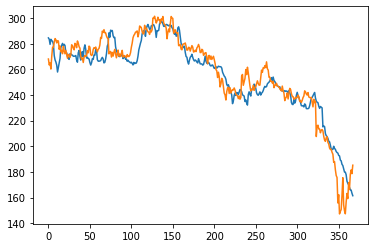

In [28]:
plt.figure()
plt.plot(y_val_pred)
plt.plot(y_val_org)
plt.show()

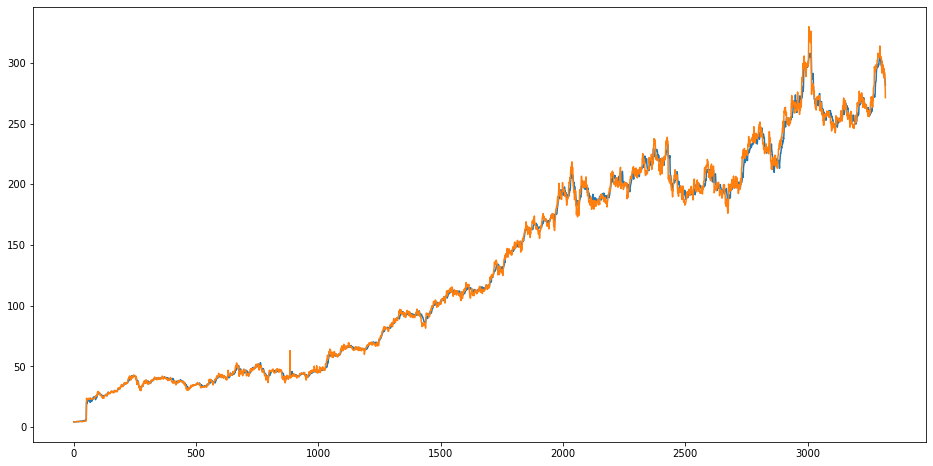

In [29]:
plt.figure(figsize=(16,8))
plt.plot(y_train_pred)
plt.plot(y_train_org)
plt.show()

In [77]:
y_train_pred[1000]

45.6650829809488

In [78]:
y_train_org[1000]

array([44.914862])